In [1]:
import yaml
import sys
sys.path.append("../")
from plugins.interfaces.diagnostics import AWAFrameGrabberDiagnostic, ROI

# define screen and trim parameters
screen = "DYG5"
magnet_info = yaml.safe_load(open("awa_config/awa_drive_magnet_config.yml"))
screen_info = yaml.safe_load(open("awa_config/awa_drive_camera_config.yml"))[screen]

In [2]:
# create Xopt objects
from xopt import VOCS
IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
        }

vocs = VOCS(
    variables = {
        "AWA:Bira3Ctrl:Ch03":[-1.0,1.0],
        "AWA:Drive:DT8H_B_S:Ctrl":[-2.1,2.1],
        "AWA:Drive:DT8V_B_S:Ctrl":[-2.1,2.1]
    },
    constraints = IMAGE_CONSTRAINTS,
    observables = ["Cx","Cy"],
)

In [3]:
vocs.variable_names

['AWA:Bira3Ctrl:Ch03', 'AWA:Drive:DT8H_B_S:Ctrl', 'AWA:Drive:DT8V_B_S:Ctrl']

In [4]:
screen_roi = ROI(
    xcenter=int(screen_info["center"][0]),
    ycenter=int(screen_info["center"][1]),
    xwidth=int(screen_info["radius"]*1.5),
    ywidth=int(screen_info["radius"]*1.5),
)

image_diagnostic = AWAFrameGrabberDiagnostic(
    roi=screen_roi, apply_bounding_box_constraint=False, visualize=False
)

In [5]:
import time
from xopt import Evaluator
from epics import caput

def evaluate(inputs: dict):
    global image_diagnostic
    # caput values
    for name, val in inputs.items():
        caput(name, val)

    # wait for changes to occur - use small wait time for interpolated measurements
    time.sleep(2.0)

    results = image_diagnostic.measure_beamsize(1, **inputs)

    # measure distance to image center
    print(results["Cx"], image_diagnostic.roi.xwidth/2)
    results["center_dist_x"] = results["Cx"] - image_diagnostic.roi.xwidth/2
    results["center_dist_y"] = results["Cy"] - image_diagnostic.roi.ywidth/2

    results["center_dist"] = (results["center_dist_x"]**2 + results["center_dist_y"]**2)**0.5
    results["time"] = time.time()
    
    return results

evaluator = Evaluator(function=evaluate)

In [6]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from gpytorch.priors.torch_priors import GammaPrior
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.generators.bayesian.bayesian_exploration import BayesianExplorationGenerator
from copy import deepcopy
sys.path.append("../bax/")

from bax_alignment import ScipyBeamAlignment
covar_module = PolynomialKernel(power=1, active_dims=[0]) * PolynomialKernel(power=1, active_dims=[1]) * PolynomialKernel(power=1, active_dims=[2])
scaled_covar_module = ScaleKernel(covar_module)   
    
# prepare options for Xopt generator
covar_module_dict = {'Cx': scaled_covar_module,'Cy': deepcopy(scaled_covar_module)}
# covar_module_dict = {}
model_constructor = StandardModelConstructor(
    covar_modules=covar_module_dict, use_low_noise_prior=True
)

algo = ScipyBeamAlignment(
    meas_dims=[0], 
    n_samples=10, 
    x_key='Cx',
    y_key='Cy',
)

generator = BaxGenerator(
    vocs=vocs, 
    gp_constructor=model_constructor, 
    algorithm=algo,
    #n_interpolate_points=5,
)

#generator = BayesianExplorationGenerator(
#    vocs=vocs, 
#    gp_constructor=model_constructor, 
#)

generator.numerical_optimizer.max_time = 10.0


In [7]:
from xopt import Xopt
X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator, strict=False, 
         dump_file="x_y_alignment3.yml")

In [8]:
X


            Xopt
________________________________
Version: 2.2.1+8.g7a7eff90.dirty
Data size: 0
Config as YAML:
dump_file: x_y_alignment3.yml
evaluator:
  function: __main__.evaluate
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  algorithm:
    n_samples: 10
  algorithm_results_file: null
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: BAX
  numerical_optimizer:
    max_iter: 2000
    max_time: 10.0
    n_restarts: 20
    name: LBFGS
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: false
vocs:
  constants: {}
  constraints:
    bb_penalty:
    - LESS_THAN
    -

In [9]:
from epics import caget_many
from xopt.utils import get_local_region
import pandas as pd
import numpy as np
current_value = dict(zip(X.vocs.variable_names, caget_many(X.vocs.variable_names)))
print(current_value)
# get small region around current point to sample
#random_sample_region = get_local_region(current_value, X.vocs, fraction=0.5)

def init_step_pattern(vocs, start_point, step_sizes):
    """
    Function that produces an list of input dicts with a starting point and subsequent single-dimensional
    steps in each variable specified by list of step_sizes.
   
    Inputs:
        vocs: the vocs object from xopt
        start_point: a list of length len(vocs.variable_names) specifying the initial point to evaluate.
                    Values must be ordered according to the order of variables given by vocs.variable_names.
        step_sizes: a list of length len(vocs.variable_names) specifying the step sizes to take for the
                    subsequent evaluations. Values must be ordered according to the order of variables given
                    by vocs.variable_names. Positive step sizes correspond to steps in positive direction.
                    Negative step sizes will be in the negative direction.
    """
    input_dicts = [{name:val for name, val in zip(vocs.variable_names, start_point)}]
    for i in range(len(vocs.variable_names)):
        for j in [1,2]:
            step = {name:val for name, val in zip(vocs.variable_names, start_point)}
            step[vocs.variable_names[i]] = start_point[i] + step_sizes[i]*j
            input_dicts += [step]
    return input_dicts


#input_dicts = init_step_pattern(vocs, [0, 0.5], [0.25, 0.5])
#print(input_dicts)
#X.evaluate_data(input_dicts)

# create a mesh
n_samples = 2
xx = np.meshgrid(
    np.linspace(-0.5, 0.0,2),
    np.linspace(-0.5, -0.0,2),
    np.linspace(0.0, 0.5,2)

)
pts = np.vstack([ele.flatten() for ele in xx])
print(pts)
X.evaluate_data({"AWA:Bira3Ctrl:Ch03":pts[0],"AWA:Drive:DT8H_B_S:Ctrl":pts[1],"AWA:Drive:DT8V_B_S:Ctrl":pts[2]})

#X.random_evaluate(2)#, custom_bounds=random_sample_region)

{'AWA:Bira3Ctrl:Ch03': 0.0, 'AWA:Drive:DT8H_B_S:Ctrl': -0.25, 'AWA:Drive:DT8V_B_S:Ctrl': 0.5}
[[-0.5 -0.5  0.   0.  -0.5 -0.5  0.   0. ]
 [-0.5 -0.5 -0.5 -0.5 -0.  -0.  -0.  -0. ]
 [ 0.   0.5  0.   0.5  0.   0.5  0.   0.5]]


CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.0.2:62521, Ignored: 192.168.2.57:62521"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Mar 14 2024 13:56:28.956138334
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.0.2:62521, Ignored: awa3.hep.anl.gov:62521"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Mar 14 2024 13:56:28.957100072
..................................................................


fitting image
111.78898780050498 155.0
fitting image
113.12323788068548 155.0
fitting image
97.14182872663037 155.0
fitting image
95.99065563816502 155.0
fitting image
151.49685015293355 155.0
fitting image
152.162852524984 155.0
fitting image
148.97096482354095 155.0
fitting image
149.50597533914976 155.0


,AWA:Bira3Ctrl:Ch03,AWA:Drive:DT8H_B_S:Ctrl,AWA:Drive:DT8V_B_S:Ctrl,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,center_dist_x,center_dist_y,center_dist,time,xopt_runtime,xopt_error
0,-0.5,-0.5,0.0,111.788988,128.173397,4.759879,26.164534,-31.526485,6611466.0,6.820298,-43.211012,-26.826603,50.861166,1.710443e+09,3.360534,False
1,-0.5,-0.5,0.5,113.123238,54.863135,4.792744,30.674823,35.039113,6656801.0,6.823266,-41.876762,-100.136865,108.540568,1.710443e+09,3.346878,False
2,0.0,-0.5,0.0,97.141829,149.679850,14.883990,15.433981,-29.356672,6801399.0,6.832598,-57.858171,-5.320150,58.102255,1.710443e+09,3.303520,False
3,0.0,-0.5,0.5,95.990656,95.179610,15.847954,16.369577,7.146088,6799653.0,6.832487,-59.009344,-59.820390,84.027268,1.710443e+09,3.261761,False
4,-0.5,-0.0,0.0,151.496850,129.240016,4.867478,26.577189,-57.477031,6618151.0,6.820737,-3.503150,-25.759984,25.997093,1.710443e+09,3.434415,False
5,-0.5,-0.0,0.5,152.162853,59.102545,4.844619,25.767895,-1.774114,6637979.0,6.822036,-2.837147,-95.897455,95.939415,1.710443e+09,3.295088,False
6,0.0,-0.0,0.0,148.970965,151.501923,12.198408,12.074780,-85.856379,6683556.0,6.825008,-6.029035,-3.498077,6.970352,1.710443e+09,3.261371,False
7,0.0,-0.0,0.5,149.505975,97.264006,12.788998,13.360462,-46.400489,6679541.0,6.824747,-5.494025,-57.735994,57.996805,1.710443e+09,3.318187,False


/home/awa/awa-badger/control_notebooks/../bax/bax_alignment.py:337: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1691.)
  Lnn = torch.cholesky(K.to_dense())
/home/awa/awa-badger/control_notebooks/../bax/bax_alignment.py:194: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.c

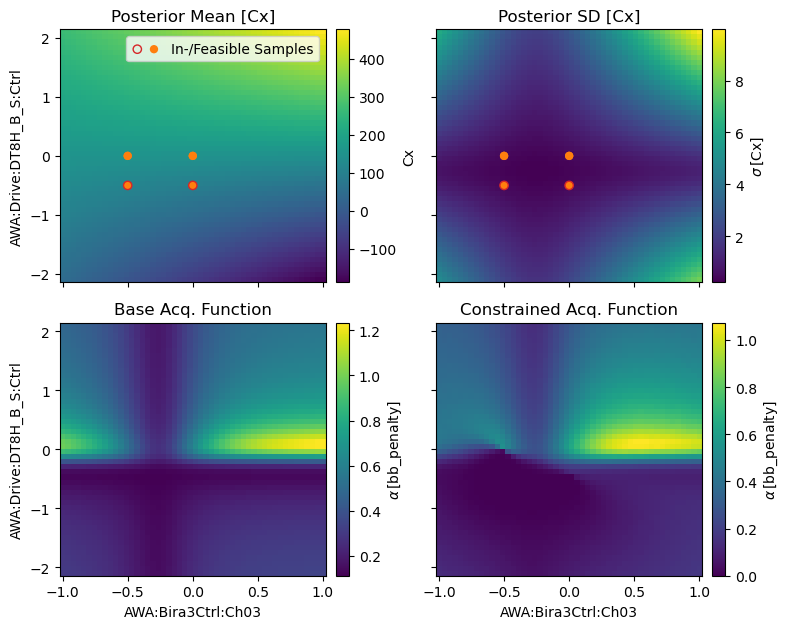

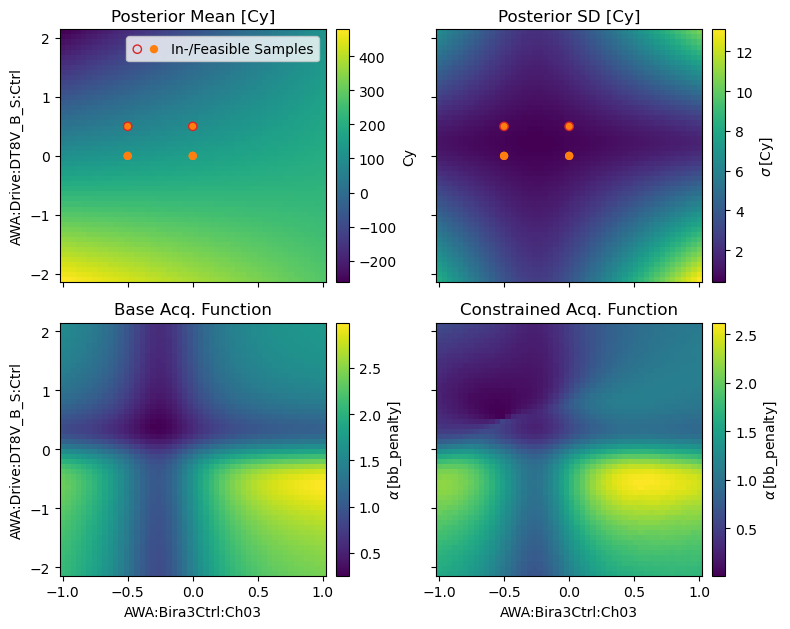

In [10]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X.generator.train_model()
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8V_B_S:Ctrl"],
    output_names=["Cy"]
)
#X_stars = X.generator.algorithm_results["X_stars"]
#for ele in X_stars:
#    ax[0,0].axhline(ele,c="C3", xmax=0.1)


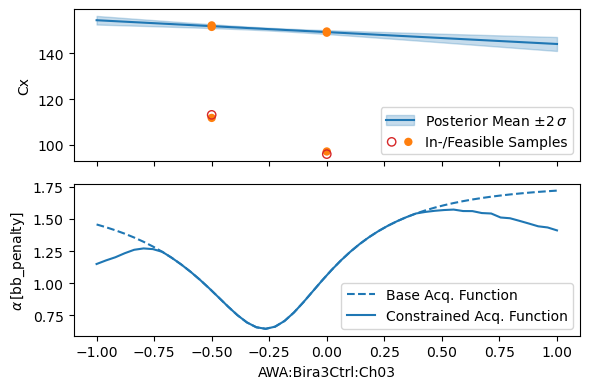

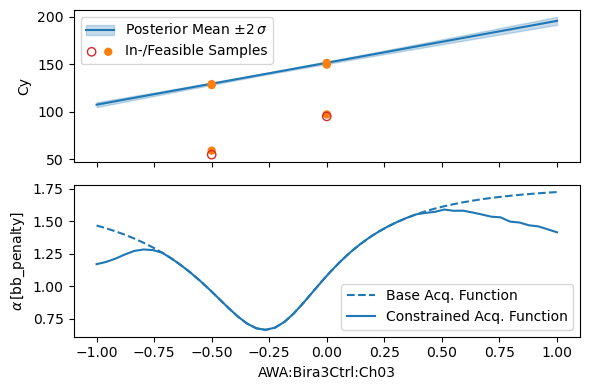

In [11]:
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":0.0,"AWA:Drive:DT8V_B_S:Ctrl":0.0},
    output_names=["Cx"]
)

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":0.0,"AWA:Drive:DT8V_B_S:Ctrl":0.0},
    output_names=["Cy"]
)

In [12]:
for i in range(10):
    X.step()

fitting image
160.7944210853244 155.0
fitting image
157.98384646299448 155.0
fitting image
160.13649992455584 155.0
fitting image
157.4035762878638 155.0
fitting image
157.19492361943992 155.0
fitting image
157.93942474444793 155.0
fitting image
157.55529656812263 155.0
fitting image
157.74069308409779 155.0
fitting image
159.05194329295026 155.0
fitting image
157.4312048186303 155.0


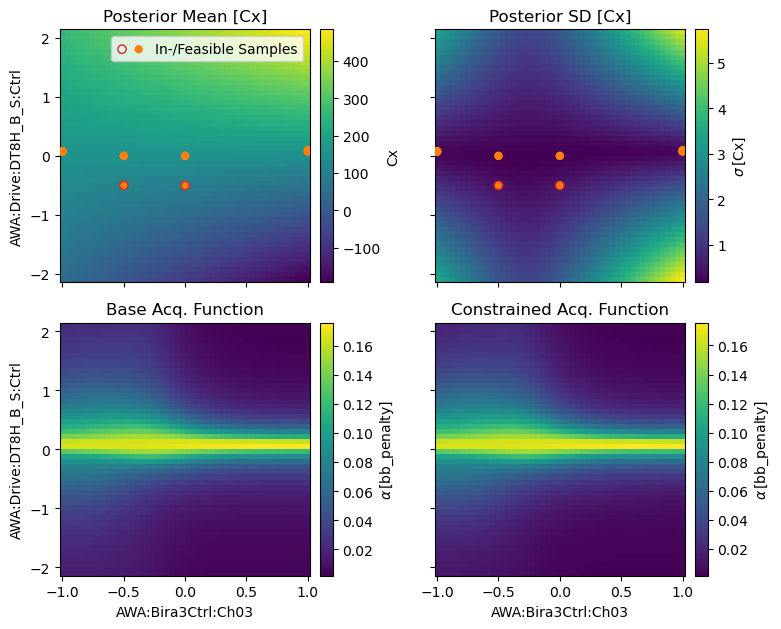

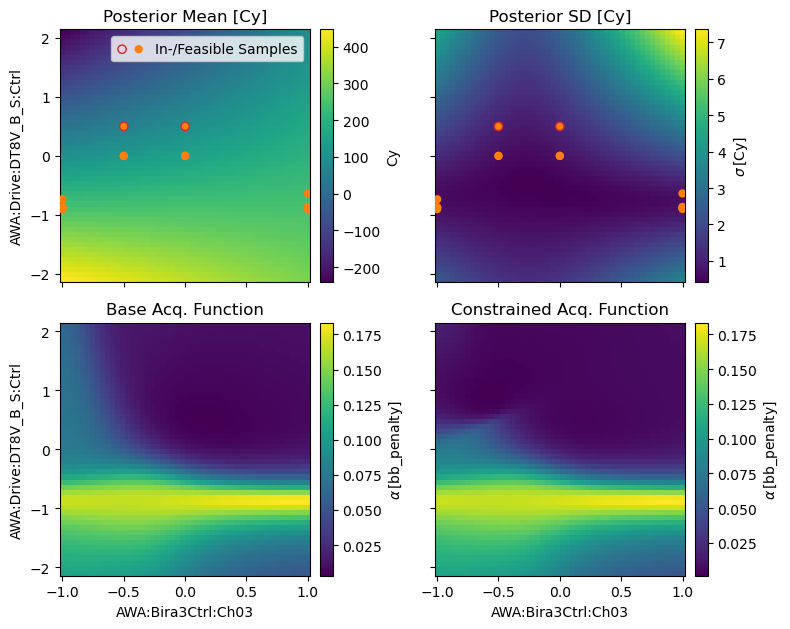

In [13]:
X.generator.train_model()
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8V_B_S:Ctrl"],
    output_names=["Cy"]
)

In [14]:
X.generator.algorithm_results

{'xs_exe': tensor([[[-1.0000,  0.0740, -0.8744],
          [ 1.0000,  0.0740, -0.8744]],
 
         [[-1.0000,  0.0760, -0.8714],
          [ 1.0000,  0.0760, -0.8714]],
 
         [[-1.0000,  0.0685, -0.8639],
          [ 1.0000,  0.0685, -0.8639]],
 
         [[-1.0000,  0.0744, -0.8896],
          [ 1.0000,  0.0744, -0.8896]],
 
         [[-1.0000,  0.0764, -0.8602],
          [ 1.0000,  0.0764, -0.8602]],
 
         [[-1.0000,  0.0771, -0.8713],
          [ 1.0000,  0.0771, -0.8713]],
 
         [[-1.0000,  0.0763, -0.8644],
          [ 1.0000,  0.0763, -0.8644]],
 
         [[-1.0000,  0.0757, -0.8662],
          [ 1.0000,  0.0757, -0.8662]],
 
         [[-1.0000,  0.0731, -0.8675],
          [ 1.0000,  0.0731, -0.8675]],
 
         [[-1.0000,  0.0724, -0.8674],
          [ 1.0000,  0.0724, -0.8674]]]),
 'ys_exe': tensor([[[157.4768, 246.0061],
          [157.4768, 246.0061]],
 
         [[157.4390, 244.8063],
          [157.4390, 244.8063]],
 
         [[156.8798, 244.4773],
    

In [15]:
from xopt.generators.bayesian.visualize import visualize_generator_model

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":0.25},
    output_names=["Cx"]
)

fig2,ax2 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.0},
    output_names=["Cx"]
)

fig3,ax3 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.1},
    output_names=["Cx"]
)

KeyError: 'AWA:Drive:DT8V_B_S:Ctrl'

In [ ]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X.generator.train_model()
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)
#X_stars = X.generator.algorithm_results["X_stars"]
#for ele in X_stars:
#    ax[0,0].axhline(ele,c="C3", xmax=0.1)
